In [24]:
import tensorflow as tf
import numpy as np

from sklearn.metrics import confusion_matrix
from scipy.stats import binom_test

# Load Test Data
test_x = np.load('test_x.npy')
test_y = np.load('test_y.npy')

# Load Model
model = tf.keras.models.load_model('new_model.h5')
print(model.summary)

# Run Test
hypothesis = model.predict_proba(tf.cast(test_x, tf.float32), batch_size=128)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_14  (None, 1280)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 721,281
Non-trainable params: 1,537,984
_________________________________________________________________


In [72]:
def get_stats(threshold=0.5):
    predicted_labels = np.where(hypothesis > threshold, 1, 0)
    c_matrix = confusion_matrix(test_y, predicted_labels)
    print('True Positives: ', c_matrix[0, 0])
    print('False Positives: ',  c_matrix[0, 1])
    print('True Negatives: ', c_matrix[1, 1])
    print('False Negatives: ',  c_matrix[1, 0])
    print()
    accuracy = (c_matrix[0, 0] + c_matrix[1, 1])/np.sum(c_matrix)
    precision = c_matrix[0, 0] / (c_matrix[0, 0] + c_matrix[0, 1])
    recall = c_matrix[0, 0] / (c_matrix[0, 0] + c_matrix[1, 0])
    specificity = c_matrix[0, 1] / (c_matrix[0, 1] + c_matrix[1, 1])
    f1_score = 2 * precision * recall/(precision + recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('Specificity: ', specificity)
    print('F1 score: ', f1_score)
    alpha = 0.05
    print()
    print('H0 = Model comes from Binomial Distribution, alpha =', alpha)
    p_value = binom_test(c_matrix[0, 0] + c_matrix[1, 1], np.sum(c_matrix), 0.5)
    print( "Null Hypothesis rejected" if p_value < alpha else "Can not reject Null Hypothesis")
    return predicted_labels

predicted_labels = get_stats()

True Positives:  1085
False Positives:  915
True Negatives:  1495
False Negatives:  505

Accuracy:  0.645
Precision:  0.5425
Recall:  0.6823899371069182
Specificity:  0.3796680497925311
F1 score:  0.6044568245125348

H0 = Model comes from Binomial Distribution, alpha = 0.05
Null Hypothesis rejected


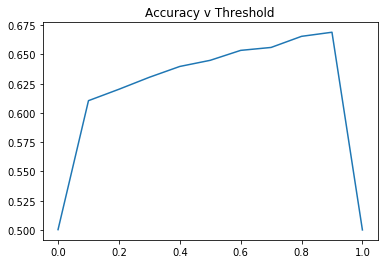

In [73]:
def get_accuracy(threshold):
    c_matrix = confusion_matrix(test_y, np.where(hypothesis > threshold,
                                                 1, 0))
    return (c_matrix[0, 0] + c_matrix[1, 1])/np.sum(c_matrix)

steps = 10

thresholds = [x/steps for x in range(steps + 1)]
accuracies = [get_accuracy(x) for x in thresholds]

import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Accuracy v Threshold")
plt.plot(thresholds, accuracies)
plt.show()

In [74]:
_ = get_stats(thresholds[np.argmax(accuracies)])

True Positives:  1453
False Positives:  547
True Negatives:  1223
False Negatives:  777

Accuracy:  0.669
Precision:  0.7265
Recall:  0.6515695067264574
Specificity:  0.30903954802259886
F1 score:  0.6869976359338061

H0 = Model comes from Binomial Distribution, alpha = 0.05
Null Hypothesis rejected


In [142]:
true_positives = np.nonzero(np.logical_and(test_y,
                                           predicted_labels).flatten())[0]
true_negatives = np.nonzero(np.logical_and(np.logical_not(test_y),
                                           np.logical_not(predicted_labels)).flatten())[0]

false_positives = np.nonzero(np.logical_and(np.logical_not(test_y),
                                            predicted_labels).flatten())[0]
false_negatives = np.nonzero(np.logical_and(test_y,
                                            np.logical_not(predicted_labels)).flatten())[0]


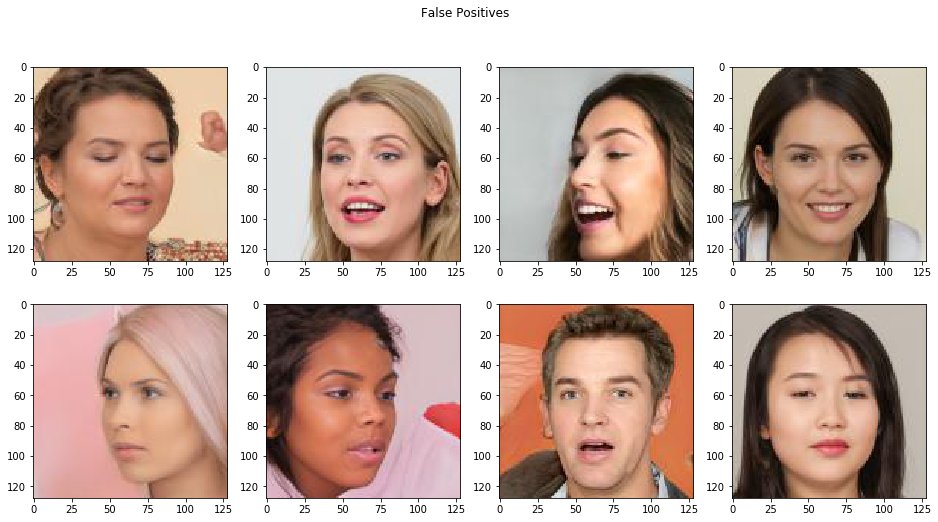

In [143]:
def show_images(images, title):
    plt.figure(figsize= (16, 8))
    plt.suptitle(title)
    n = 2
    m = 4
    k = 1
    indices = np.random.choice(len(images), n*m)
    for i in range(n):
        for j in range(m):
            plt.subplot(n, m, k)
            plt.imshow(test_x[images[indices[k - 1]], :, :, :])
            k += 1
    plt.show()

show_images(false_positives, 'False Positives')

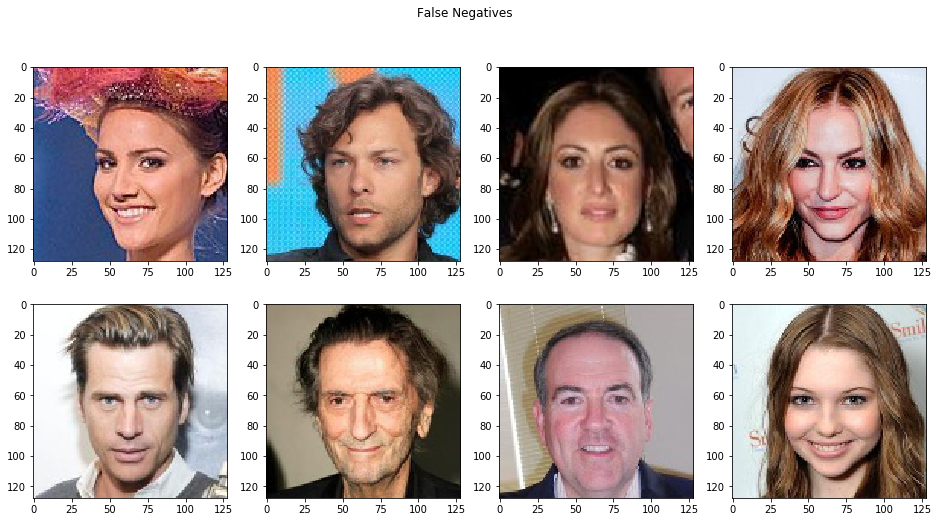

In [144]:
show_images(false_negatives, 'False Negatives')

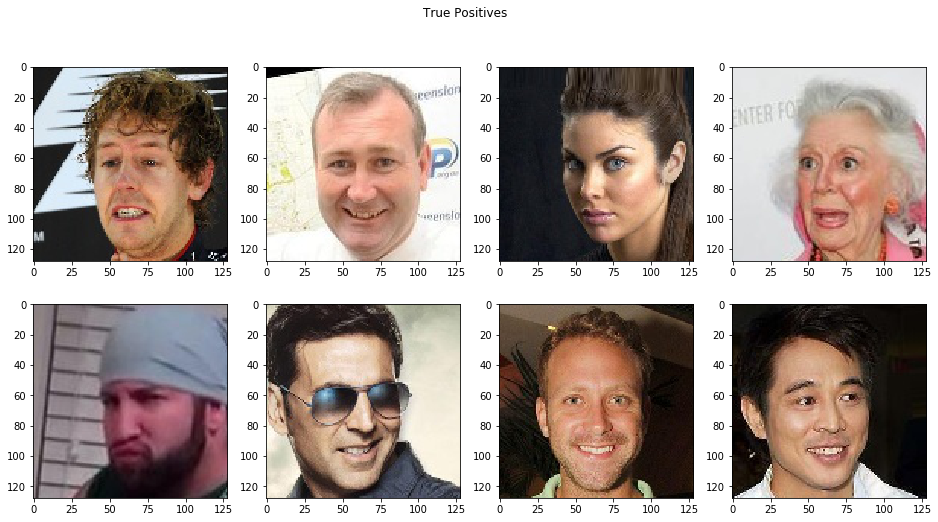

In [145]:
show_images(true_positives, 'True Positives')

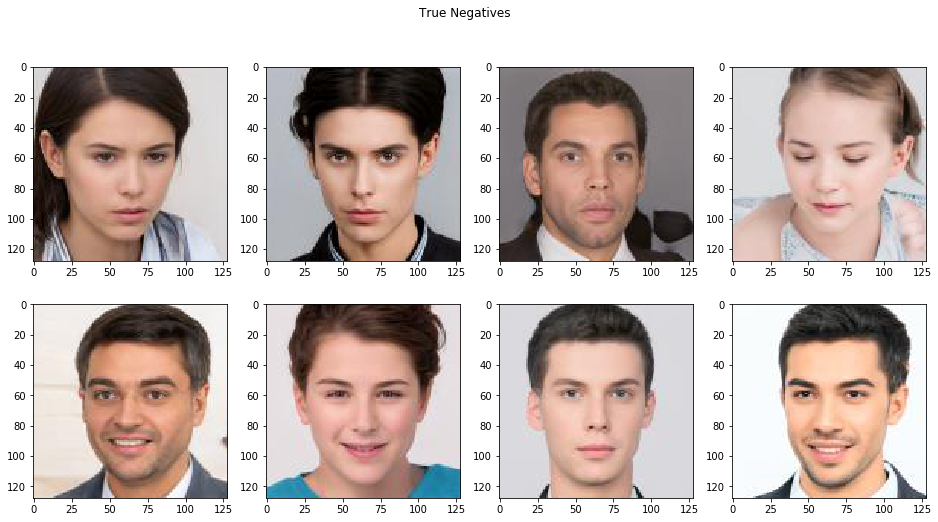

In [146]:
show_images(true_negatives, 'True Negatives')